In [1]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from linearmodels import PanelOLS

In [2]:
data = pd.read_csv("Data/master_data.csv")
data.drop(columns=["Unnamed: 0"], inplace=True)
data = data.dropna()

In [3]:
#sum stats
sum_stats = data[['price', 'vol', 'return', 'share_passive', 'abnormal_return', '3day_vol']].describe()
sum_stats

,price,vol,return,share_passive,abnormal_return,3day_vol
count,301734.000000,3.017340e+05,301734.000000,301734.000000,301734.000000,301734.000000
mean,59.140901,1.996014e+06,0.000281,0.190174,0.037898,0.623535
std,156.190576,8.831199e+06,0.046306,0.161066,0.053039,2.042588
min,0.033500,1.070000e+02,-0.804171,0.000006,0.000000,0.000000
25%,8.100000,1.376720e+05,-0.017578,0.046114,0.010753,0.075130
50%,23.200001,4.619940e+05,-0.000147,0.158134,0.024592,0.207445
75%,60.910000,1.414058e+06,0.016492,0.262194,0.048411,0.560000
max,5819.680176,1.144059e+09,5.382716,0.947847,5.751672,216.289718


In [4]:
data['passive_q'] = pd.qcut(data['share_passive'], q=4, labels=False) + 1

In [5]:
avg_ab_returns = (data.groupby(['days_from_earn', 'passive_q'])['abnormal_return'].mean().reset_index())

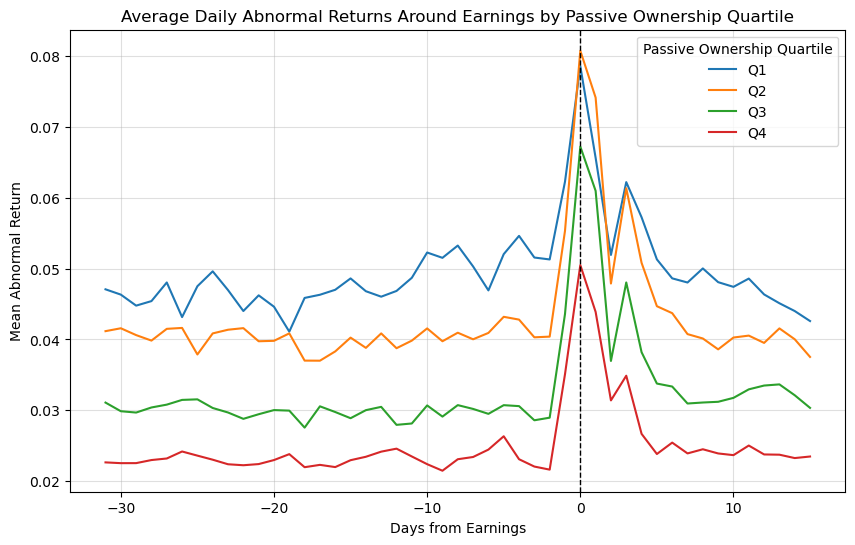

In [6]:
plt.figure(figsize=(10,6))
for q in sorted(data['passive_q'].unique()):
    subset = avg_ab_returns[avg_ab_returns['passive_q'] == q]
    plt.plot(subset['days_from_earn'], subset['abnormal_return'], label=f'Q{q}')

plt.axvline(0, color='black', linestyle='--', linewidth=1)
plt.title('Average Daily Abnormal Returns Around Earnings by Passive Ownership Quartile')
plt.xlabel('Days from Earnings')
plt.ylabel('Mean Abnormal Return')
plt.legend(title='Passive Ownership Quartile')
plt.grid(True, alpha = 0.4)
plt.show()

In [7]:
avg_3volatility = (data.groupby(['days_from_earn', 'passive_q'])['3day_vol'].mean().reset_index())

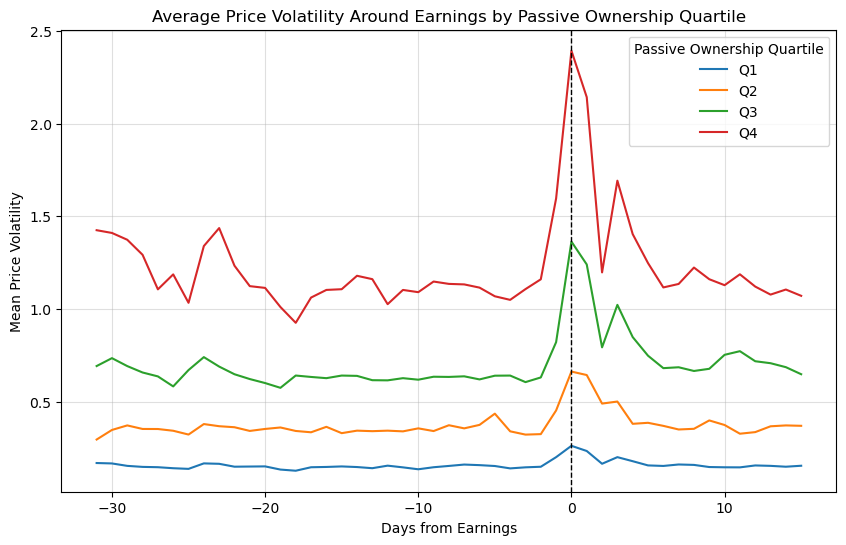

In [8]:
plt.figure(figsize=(10,6))
for q in sorted(data['passive_q'].unique()):
    subset = avg_3volatility[avg_3volatility['passive_q'] == q]
    plt.plot(subset['days_from_earn'], subset['3day_vol'], label=f'Q{q}')

plt.axvline(0, color='black', linestyle='--', linewidth=1)
plt.title('Average Price Volatility Around Earnings by Passive Ownership Quartile')
plt.xlabel('Days from Earnings')
plt.ylabel('Mean Price Volatility')
plt.legend(title='Passive Ownership Quartile')
plt.grid(True, alpha = 0.4)
plt.show()

In [9]:
for k in range(-29, 16):
    data[f'day_{k}'] = (data['days_from_earn'] == k).astype(int)

In [10]:
data['Date'] = pd.to_datetime(data['Date'])
df = data.set_index(['ticker', 'Date'])
event_dummies = [f'day_{k}' for k in range(-29, 16) if k != -1]
X = df[event_dummies + ['share_passive']]
y = df['abnormal_return']
model = PanelOLS(y, X, entity_effects=True, time_effects=False)
res = model.fit(cov_type='clustered', cluster_entity=True)
print(res.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:        abnormal_return   R-squared:                        0.0219
Estimator:                   PanelOLS   R-squared (Between):             -0.2784
No. Observations:              301734   R-squared (Within):               0.0219
Date:                Sun, Oct 12 2025   R-squared (Overall):             -0.1219
Time:                        13:07:10   Log-likelihood                 4.855e+05
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      148.13
Entities:                        3695   P-value                           0.0000
Avg Obs:                       81.660   Distribution:               F(45,297994)
Min Obs:                      10.0000                                           
Max Obs:                       109.00   F-statistic (robust):             46.096
                            

In [11]:
for k in range(-29, 16):
    if k != -1:
        df[f'day_{k}_passive'] = df[f'day_{k}'] * df['share_passive']

X = df[event_dummies + [f'{d}_passive' for d in event_dummies]]
model = PanelOLS(y, X, entity_effects=False, time_effects=False)
res = model.fit(cov_type='clustered', cluster_entity=True)
print(res.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:        abnormal_return   R-squared:                        0.3387
Estimator:                   PanelOLS   R-squared (Between):              0.7795
No. Observations:              301734   R-squared (Within):              -0.0260
Date:                Sun, Oct 12 2025   R-squared (Overall):              0.3387
Time:                        13:07:19   Log-likelihood                 4.581e+05
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      1755.4
Entities:                        3695   P-value                           0.0000
Avg Obs:                       81.660   Distribution:               F(88,301646)
Min Obs:                      10.0000                                           
Max Obs:                       109.00   F-statistic (robust):             216.72
                            

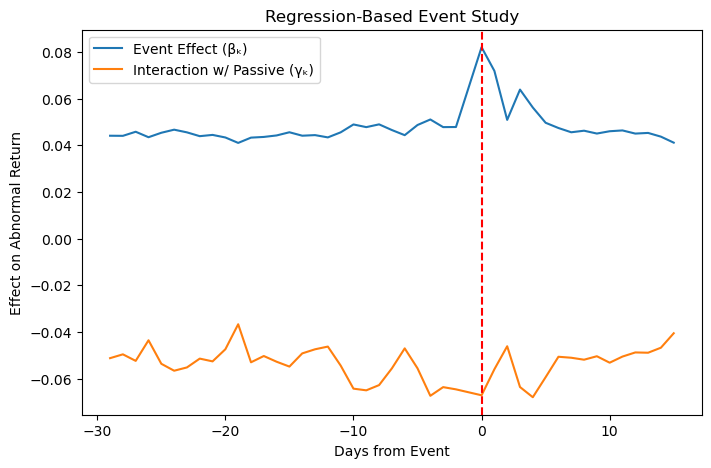

In [12]:
betas = [res.params[f'day_{k}'] for k in range(-29, 16) if k != -1]
gammas = [res.params[f'day_{k}_passive'] for k in range(-29, 16) if k != -1]
days = [k for k in range(-29, 16) if k != -1]

plt.figure(figsize=(8,5))
plt.plot(days, betas, label='Event Effect (βₖ)')
plt.plot(days, gammas, label='Interaction w/ Passive (γₖ)')
plt.axvline(0, color='red', linestyle='--')
plt.xlabel('Days from Event')
plt.ylabel('Effect on Abnormal Return')
plt.title('Regression-Based Event Study')
plt.legend()
plt.show()

In [13]:
X = df[event_dummies + [f'{d}_passive' for d in event_dummies]]
model = PanelOLS(y, X, entity_effects=True, time_effects=False)
res = model.fit(cov_type='clustered', cluster_entity=True)
print(res.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:        abnormal_return   R-squared:                        0.0221
Estimator:                   PanelOLS   R-squared (Between):             -0.1143
No. Observations:              301734   R-squared (Within):               0.0221
Date:                Sun, Oct 12 2025   R-squared (Overall):             -0.0423
Time:                        13:07:31   Log-likelihood                 4.855e+05
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      76.512
Entities:                        3695   P-value                           0.0000
Avg Obs:                       81.660   Distribution:               F(88,297951)
Min Obs:                      10.0000                                           
Max Obs:                       109.00   F-statistic (robust):             27.726
                            

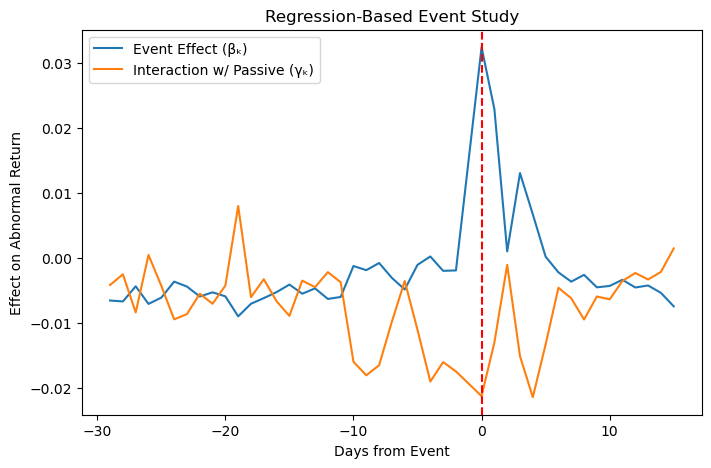

In [14]:
betas = [res.params[f'day_{k}'] for k in range(-29, 16) if k != -1]
gammas = [res.params[f'day_{k}_passive'] for k in range(-29, 16) if k != -1]
days = [k for k in range(-29, 16) if k != -1]

plt.figure(figsize=(8,5))
plt.plot(days, betas, label='Event Effect (βₖ)')
plt.plot(days, gammas, label='Interaction w/ Passive (γₖ)')
plt.axvline(0, color='red', linestyle='--')
plt.xlabel('Days from Event')
plt.ylabel('Effect on Abnormal Return')
plt.title('Regression-Based Event Study')
plt.legend()
plt.show()

In [15]:
y = df['3day_vol']
model = PanelOLS(y, X, entity_effects=True, time_effects=False)
res = model.fit(cov_type='clustered', cluster_entity=True)
print(res.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:               3day_vol   R-squared:                        0.0126
Estimator:                   PanelOLS   R-squared (Between):             -0.0449
No. Observations:              301734   R-squared (Within):               0.0126
Date:                Sun, Oct 12 2025   R-squared (Overall):             -0.0173
Time:                        13:07:44   Log-likelihood                -5.377e+05
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      43.253
Entities:                        3695   P-value                           0.0000
Avg Obs:                       81.660   Distribution:               F(88,297951)
Min Obs:                      10.0000                                           
Max Obs:                       109.00   F-statistic (robust):             11.486
                            

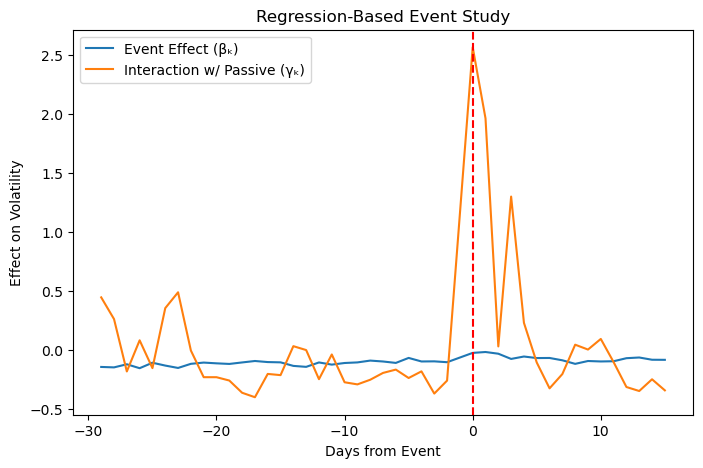

In [16]:
betas = [res.params[f'day_{k}'] for k in range(-29, 16) if k != -1]
gammas = [res.params[f'day_{k}_passive'] for k in range(-29, 16) if k != -1]
days = [k for k in range(-29, 16) if k != -1]

plt.figure(figsize=(8,5))
plt.plot(days, betas, label='Event Effect (βₖ)')
plt.plot(days, gammas, label='Interaction w/ Passive (γₖ)')
plt.axvline(0, color='red', linestyle='--')
plt.xlabel('Days from Event')
plt.ylabel('Effect on Volatility')
plt.title('Regression-Based Event Study')
plt.legend()
plt.show()

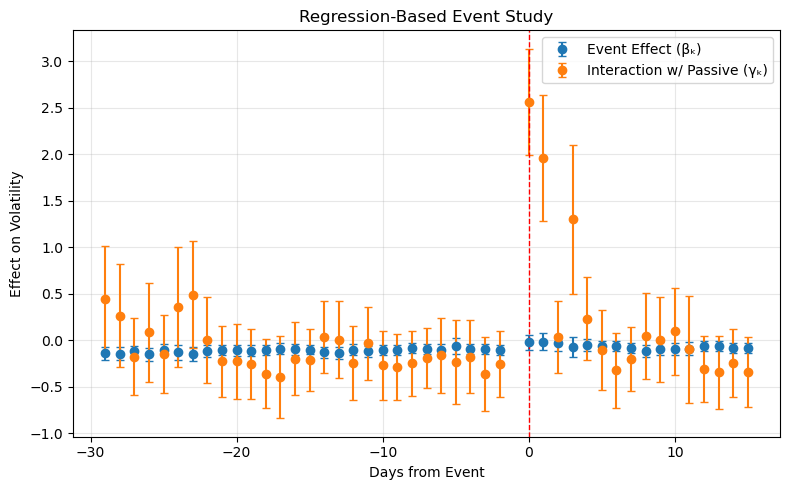

In [17]:
beta_se = [res.std_errors[f'day_{k}'] for k in days]
gamma_se = [res.std_errors[f'day_{k}_passive'] for k in days]
beta_lower = np.array(betas) - 1.96 * np.array(beta_se)
beta_upper = np.array(betas) + 1.96 * np.array(beta_se)
gamma_lower = np.array(gammas) - 1.96 * np.array(gamma_se)
gamma_upper = np.array(gammas) + 1.96 * np.array(gamma_se)

plt.figure(figsize=(8,5))
plt.errorbar(days, betas, yerr=[np.array(betas) - beta_lower, beta_upper - np.array(betas)],
    fmt='o', capsize=3, label='Event Effect (βₖ)', color='tab:blue')

plt.errorbar(days, gammas, yerr=[np.array(gammas) - gamma_lower, gamma_upper - np.array(gammas)],
    fmt='o', capsize=3, label='Interaction w/ Passive (γₖ)', color='tab:orange')

plt.axvline(0, color='red', linestyle='--', linewidth=1)
plt.xlabel('Days from Event')
plt.ylabel('Effect on Volatility')
plt.title('Regression-Based Event Study')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [18]:
for k in range(-29, 16):
    if k != -1:
        df[f'day_{k}_passive'] = df[f'day_{k}'] * df['share_passive']

X = df[event_dummies + [f'{d}_passive' for d in event_dummies]]
model = PanelOLS(y, X, entity_effects=False, time_effects=False)
res = model.fit(cov_type='clustered', cluster_entity=True)
print(res.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:               3day_vol   R-squared:                        0.1167
Estimator:                   PanelOLS   R-squared (Between):              0.2249
No. Observations:              301734   R-squared (Within):              -0.0103
Date:                Sun, Oct 12 2025   R-squared (Overall):              0.1167
Time:                        13:07:53   Log-likelihood                -6.384e+05
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      453.06
Entities:                        3695   P-value                           0.0000
Avg Obs:                       81.660   Distribution:               F(88,301646)
Min Obs:                      10.0000                                           
Max Obs:                       109.00   F-statistic (robust):             25.600
                            

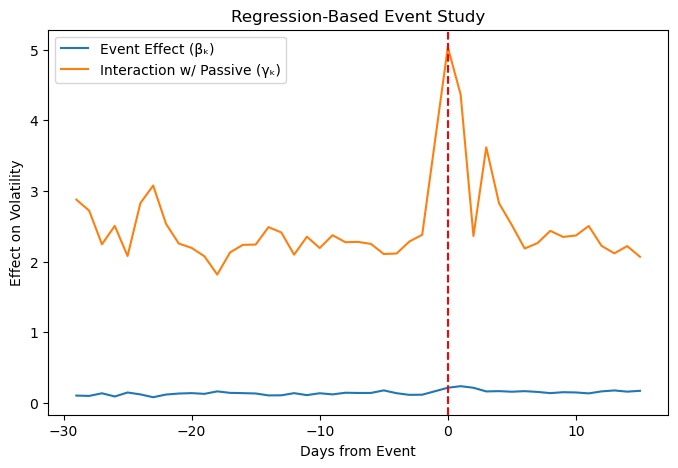

In [19]:
betas = [res.params[f'day_{k}'] for k in range(-29, 16) if k != -1]
gammas = [res.params[f'day_{k}_passive'] for k in range(-29, 16) if k != -1]
days = [k for k in range(-29, 16) if k != -1]

plt.figure(figsize=(8,5))
plt.plot(days, betas, label='Event Effect (βₖ)')
plt.plot(days, gammas, label='Interaction w/ Passive (γₖ)')
plt.axvline(0, color='red', linestyle='--')
plt.xlabel('Days from Event')
plt.ylabel('Effect on Volatility')
plt.title('Regression-Based Event Study')
plt.legend()
plt.show()